In [ ]:
!pip install torch
!pip install transformers[torch]
!pip install datasets
! pip install seqeval
! pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=s

In [ ]:
from transformers import RobertaTokenizer, RobertaForTokenClassification, Trainer, TrainingArguments, EarlyStoppingCallback, AutoTokenizer
from datasets import load_dataset, Dataset
from seqeval.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import torch
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Ready Dataset Prep

In [ ]:
train_dataset = load_dataset("telord/mountains-ner-dataset", split="train")
valid_dataset = load_dataset("telord/mountains-ner-dataset", split="val")
test_dataset  = load_dataset("telord/mountains-ner-dataset", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/578 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/811k [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/106k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/109k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3827 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/478 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/479 [00:00<?, ? examples/s]

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3827
Validation dataset size: 478
Test dataset size: 479


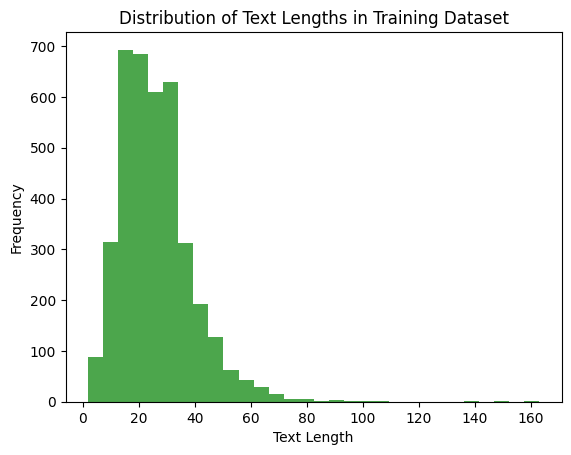

In [ ]:
# calculating text lengths
text_lengths = [len(example['tokens']) for example in train_dataset]

# plotting the distribution
plt.hist(text_lengths, bins=30, alpha=0.7, color='green')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths in Training Dataset")
plt.show()

In [ ]:
# Aligning labels with a mapping is only supported for ClassLabel column or Sequence column with the inner type ClassLabel

# label2id = {'O': 0, 'B-MOUNTAIN': 1, 'I-MOUNTAIN': 2}

# train_dataset = train_dataset.align_labels_with_mapping(label2id, "labels")
# valid_dataset = valid_dataset.align_labels_with_mapping(label2id, "labels")
# test_dataset = test_dataset.align_labels_with_mapping(label2id, "labels")

In [ ]:
train_dataset[0]

{'sentence': 'Virender Sehwag and Harbhajan Singh were not named in the Indian squad due to recent poor performances while Irfan Pathan and Munaf Patel were not fully fit .',
 'tokens': ['Virender',
  'Sehwag',
  'and',
  'Harbhajan',
  'Singh',
  'were',
  'not',
  'named',
  'in',
  'the',
  'Indian',
  'squad',
  'due',
  'to',
  'recent',
  'poor',
  'performances',
  'while',
  'Irfan',
  'Pathan',
  'and',
  'Munaf',
  'Patel',
  'were',
  'not',
  'fully',
  'fit',
  '.'],
 'labels': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

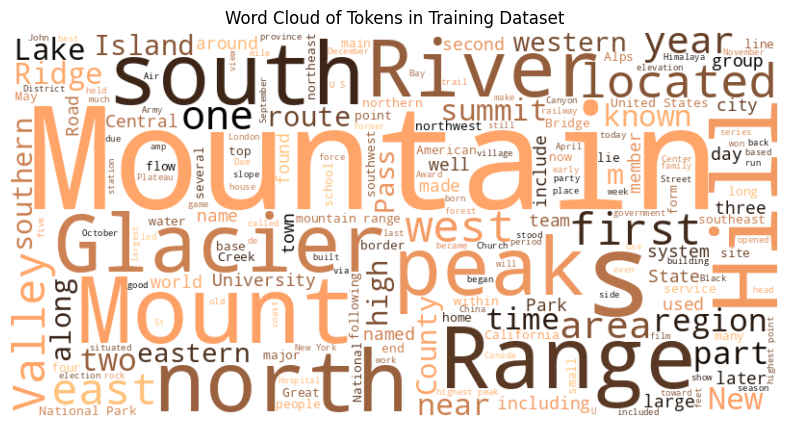

In [ ]:
# generating a word cloud for tokens
all_tokens = [token for example in train_dataset for token in example['tokens']]
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='copper_r').generate(" ".join(all_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Tokens in Training Dataset")
plt.show()


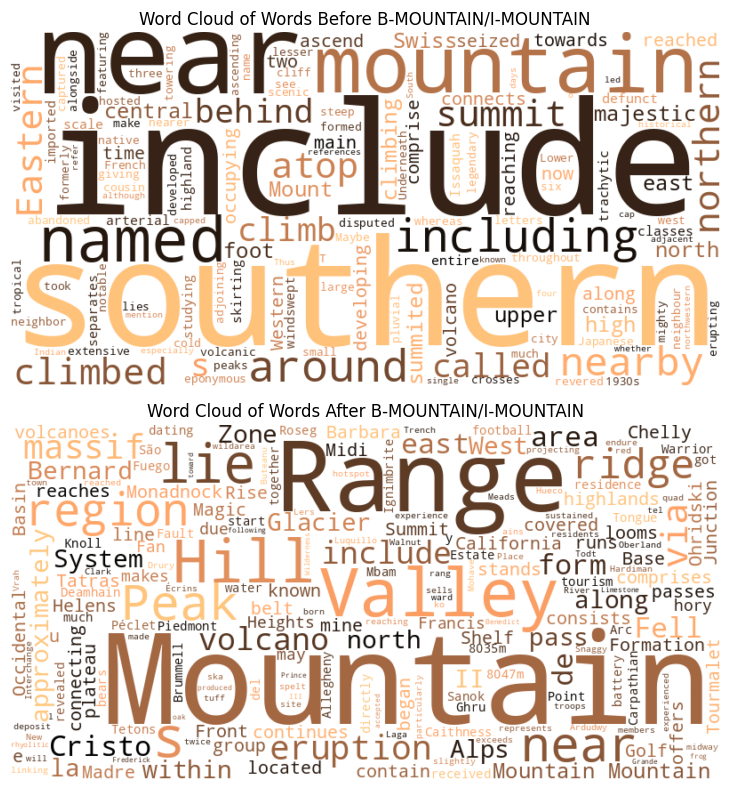

In [ ]:
# lists of words preceeding or standing after tokens labeled B-MOUNTAIN/I-MOUNTAIN
words_before = []
words_after = []

# iretating through the dataset
for example in train_dataset:
    tokens = example['tokens']
    labels = example['labels']
    for i, label in enumerate(labels):
        if label==1:
            # a word before B-MOUNTAIN
            if i > 0:
                words_before.append(tokens[i - 1])
            # a word after B-MOUNTAIN and not I-MOUNTAIN
            if i < len(tokens) - 1 and labels[i+1]!=2:
                words_after.append(tokens[i + 1])
            # a word after a B-MOUNTAIN and I-MOUNTAIN pair
            elif i < len(tokens) - 1 and labels[i+1]==2:
                words_after.append(tokens[i + 2])

# generating a Word Cloud for words preceeding mountains
wordcloud_before = WordCloud(width=800, height=400, background_color='white', colormap='copper_r').generate(" ".join(words_before))

# generating a Word Cloud for words after mountains
wordcloud_after = WordCloud(width=800, height=400, background_color='white', colormap='copper_r').generate(" ".join(words_after))

# plotting the Word Clouds
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Words Before B-MOUNTAIN/I-MOUNTAIN")

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_after, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Words After B-MOUNTAIN/I-MOUNTAIN")

plt.tight_layout()
plt.show()


In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

def convert_to_features(batch):
    # tokenization for tokens of each sent in batch
    encoding = tokenizer(batch['tokens'], truncation=True, padding='longest', is_split_into_words=True)

    # labels to indexes (for the custom dataset)
    # label_map = {'O': 0, 'B-MOUNTAIN': 1, 'I-MOUNTAIN': 2}

    # processing labels for each sentence in batch
    all_labels = batch['labels']
    label_ids_batch = []
    for labels in all_labels:
        # label_ids = [label_map[label] for label in labels]
        label_ids = [label for label in labels]
        label_ids_batch.append(label_ids)

    # aligning labels to their ids
    encoding['labels'] = label_ids_batch
    return encoding

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# applying the tokenizer to the dataset
train_dataset = train_dataset.map(convert_to_features,
                      remove_columns=['sentence', "tokens"],
                                  batched=True)
valid_dataset = valid_dataset.map(convert_to_features,
                      remove_columns=['sentence', "tokens"],
                                  batched=True)
test_dataset = test_dataset.map(convert_to_features,
                      remove_columns=['sentence', "tokens"],
                                batched=True)

Map:   0%|          | 0/3827 [00:00<?, ? examples/s]

Map:   0%|          | 0/478 [00:00<?, ? examples/s]

Map:   0%|          | 0/479 [00:00<?, ? examples/s]

In [ ]:
train_dataset.column_names

['labels', 'input_ids', 'attention_mask']

In [ ]:
# # checking consistency between tokens and tags
# for example in train_dataset:
#     assert len(example['input_ids']) == len(example['token_type_ids']), "Mismatch between tokens and tags!"
# print("All token-tag pairs are consistent.")

KeyError: 'token_type_ids'

In [ ]:
train_dataset[0]

### Custom Dataset Prep

In [ ]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="/content/fixed_mountains_dataset.json", field='data', split="train")

print(dataset[-1])

In [ ]:
invalid_sentences = []

for item in dataset:
    tokens = item['tokens']
    labels = item['labels']

    # checking tokens and labels consistency
    if len(tokens) != len(labels):
        invalid_sentences.append(item['sentence_id'])

if invalid_sentences:
    print(invalid_sentences)

In [ ]:
# applying tokenization
dataset = dataset.map(convert_to_features,
                      remove_columns=["tokens", "labels"],
                      batched=True)

# splitting to train and test
data_splitted = dataset.train_test_split(test_size=0.15)
train0_dataset = data_splitted['train']
test_dataset = data_splitted['test']

# further splitting to train and val
train_splitted = train0_dataset.train_test_split(test_size=0.1)
train_dataset = train_splitted['train']
val_dataset = train_splitted['test']


### Weighting Classes

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# weighting the classes
class_weights = compute_class_weight('balanced', classes=np.unique([0, 1, 2]), y=np.concatenate(train_dataset[:]['labels']))  # 0 = 'O', 1 = 'B-MOUNTAIN', 2 = 'I-MOUNTAIN'
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(class_weights)

tensor([ 0.3528, 11.9007, 12.3141])


### Training

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    label_list = ['O', 'B-MOUNTAIN', 'I-MOUNTAIN']
    true_labels = [
        [label_list[label] for label in label_seq if label != -100]
        for label_seq in labels
    ]
    pred_labels = [
        [label_list[pred] for pred, label in zip(pred_seq, label_seq) if label != -100]
        for pred_seq, label_seq in zip(predictions, labels)
    ]
    print("Len true: ", len(true_labels))
    print(true_labels)
    print("Len pred: ", len(pred_labels))
    print(pred_labels)

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    # report = classification_report(true_labels, pred_labels)
    # print(report)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# setting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=3)
# model = AutoModelForTokenClassification.from_pretrained("botryan96/GeoBERT", from_tf=True, num_labels=3)
model = RobertaForTokenClassification.from_pretrained("FacebookAI/roberta-base", num_labels=3)
model.to(device)

# defining training params
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy = 'epoch',
    # eval_steps=100,
    logging_dir='./logs',
    logging_steps=100,
    # save_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    dataloader_num_workers=4,
    save_total_limit=2,
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16 = True,
    # learning_rate = 1e-04,
    weight_decay = 0.01
)

# early stopping params
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=5,
    early_stopping_threshold=0.0005
)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


input_ids
attention_mask
labels


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.202900,0.162277,0.250000,0.173529,0.204861
2,0.160500,0.149662,0.485714,0.200000,0.283333
3,0.116300,0.122863,0.613497,0.294118,0.397614
4,0.102400,0.119494,0.447273,0.361765,0.400000
5,0.084400,0.107887,0.573333,0.379412,0.456637
6,0.065800,0.121959,0.493939,0.479412,0.486567
7,0.059400,0.121044,0.498168,0.400000,0.443719
8,0.049800,0.135768,0.533333,0.470588,0.500000
9,0.048600,0.139037,0.498423,0.464706,0.480974
10,0.040000,0.174036,0.525180,0.429412,0.472492


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  478
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O'], ['B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', '

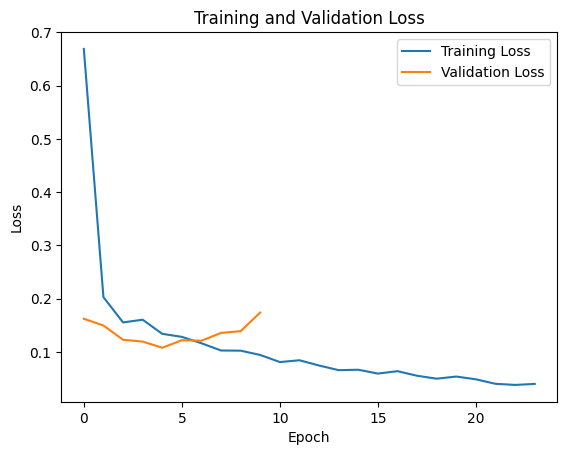

In [ ]:
from transformers import DataCollatorForTokenClassification
import torch.nn as nn

data_collator = DataCollatorForTokenClassification(tokenizer)
for batch in data_collator(train_dataset):
    print(batch)

class WeightedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        # using class weights for the loss
        self.loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, labels):
        return self.loss_fn(logits, labels)

# setting the weighted loss
model.loss_fn = WeightedCrossEntropyLoss(class_weights)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


train_result = trainer.train()

trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

# loss visualization
train_loss = trainer.state.log_history
train_losses = [entry['loss'] for entry in train_loss if 'loss' in entry]
print(len(train_losses))
eval_losses = [entry['eval_loss'] for entry in train_loss if 'eval_loss' in entry]
print(len(eval_losses))

plt.plot(train_losses, label="Training Loss")
plt.plot(eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
print(trainer.state.log_history)

[{'loss': 0.6687, 'grad_norm': 0.7874054908752441, 'learning_rate': 9.7e-06, 'epoch': 0.4166666666666667, 'step': 100}, {'loss': 0.2029, 'grad_norm': 1.1092679500579834, 'learning_rate': 1.97e-05, 'epoch': 0.8333333333333334, 'step': 200}, {'eval_loss': 0.1622767150402069, 'eval_precision': 0.25, 'eval_recall': 0.17352941176470588, 'eval_f1': 0.2048611111111111, 'eval_runtime': 1.8488, 'eval_samples_per_second': 258.551, 'eval_steps_per_second': 16.227, 'epoch': 1.0, 'step': 240}, {'loss': 0.1554, 'grad_norm': 1.2828912734985352, 'learning_rate': 2.97e-05, 'epoch': 1.25, 'step': 300}, {'loss': 0.1605, 'grad_norm': 1.4386415481567383, 'learning_rate': 3.97e-05, 'epoch': 1.6666666666666665, 'step': 400}, {'eval_loss': 0.14966218173503876, 'eval_precision': 0.4857142857142857, 'eval_recall': 0.2, 'eval_f1': 0.2833333333333333, 'eval_runtime': 1.8286, 'eval_samples_per_second': 261.396, 'eval_steps_per_second': 16.406, 'epoch': 2.0, 'step': 480}, {'loss': 0.134, 'grad_norm': 1.951056599617

In [ ]:
best_metric = trainer.state.best_metric
best_checkpoint = trainer.state.best_model_checkpoint

print(f"Best Metric: {best_metric}")
print(f"Best Model Checkpoint: {best_checkpoint}")

best_epoch_log = next(
    (log for log in trainer.state.log_history if log.get("eval_loss") == best_metric),
    None
)

if best_epoch_log:
    print("Detailed Best Epoch Results:")
    for key, value in best_epoch_log.items():
        print(f"{key}: {value}")
else:
    print("No detailed log found for the best metric.")


Best Metric: 0.10788735002279282
Best Model Checkpoint: ./results/checkpoint-1200
Detailed Best Epoch Results:
eval_loss: 0.10788735002279282
eval_precision: 0.5733333333333334
eval_recall: 0.37941176470588234
eval_f1: 0.45663716814159294
eval_runtime: 1.8269
eval_samples_per_second: 261.639
eval_steps_per_second: 16.421
epoch: 5.0
step: 1200


In [ ]:
from transformers import Trainer, TrainingArguments

# testing params
test_args = TrainingArguments(
    output_dir='./results',
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
)

tester = Trainer(
    model=model,
    args=test_args,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = tester.evaluate(test_dataset)
print(results)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Len true:  479
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['B-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN'

### Testing

In [ ]:
from sklearn.metrics import classification_report

predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

flat_pred_labels = []
flat_true_labels = []

for i in range(len(pred_labels)):
    pred_label = pred_labels[i][true_labels[i] != -100]
    true_label = true_labels[i][true_labels[i] != -100]

    flat_pred_labels.extend(pred_label)
    flat_true_labels.extend(true_label)

print("Flat Pred:")
print(flat_pred_labels)
print("Flat True:")
print(flat_true_labels)

report = classification_report(flat_true_labels, flat_pred_labels, target_names=["O", "B-MOUNTAIN", "I-MOUNTAIN"])
print(report)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Len true:  479
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O'], ['B-MOUNTAIN', 'O', 'B-MOUNTAIN', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN', 'O', 'B-MOUNTAIN', 'I-MOUNTAIN'

In [ ]:
sentence = "The Alps (/ælps/)[a] are one of the highest and most extensive mountain ranges in Europe,[b][2] stretching approximately 1,200 km (750 mi) across eight Alpine countries (from west to east): Monaco, France, Switzerland, Italy, Liechtenstein, Germany, Austria and Slovenia.[c][4]"
# sentence = [
#                 "Mount",
#                 "Everest",
#                 "is",
#                 "the",
#                 "highest",
#                 "mountain",
#                 "on",
#                 "Earth",
#                 "."
#             ]
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, is_split_into_words=False)
inputs = inputs.to(device)

# predicting
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

token_ids = inputs["input_ids"][0].tolist()
tokens = tokenizer.convert_ids_to_tokens(token_ids)
pred_labels = predictions[0].tolist()

label_map = {0: 'O', 1: 'B-MOUNTAIN', 2: 'I-MOUNTAIN'}

predicted_labels = [label_map[label] for label in pred_labels]  # labels to strings

for idx, (token, label) in enumerate(zip(tokens, predicted_labels)):
  print(f"Token ID: {token_ids[idx]} - Token: {token} - Label: {label}")

mountain_name = []
for token, label in zip(tokens, predicted_labels):
    if label == 'B-MOUNTAIN' or label == 'I-MOUNTAIN':
            mountain_name.append(token)

# getting the mountains names
mountain_name = tokenizer.convert_tokens_to_string(mountain_name)

print("Mountain Name:", mountain_name)


Token ID: 0 - Token: <s> - Label: O
Token ID: 133 - Token: The - Label: B-MOUNTAIN
Token ID: 30232 - Token: ĠAlps - Label: I-MOUNTAIN
Token ID: 48229 - Token: Ġ(/ - Label: O
Token ID: 30422 - Token: Ã¦ - Label: O
Token ID: 462 - Token: l - Label: O
Token ID: 3275 - Token: ps - Label: O
Token ID: 43521 - Token: /) - Label: O
Token ID: 10975 - Token: [ - Label: O
Token ID: 102 - Token: a - Label: O
Token ID: 742 - Token: ] - Label: O
Token ID: 32 - Token: Ġare - Label: O
Token ID: 65 - Token: Ġone - Label: O
Token ID: 9 - Token: Ġof - Label: O
Token ID: 5 - Token: Ġthe - Label: O
Token ID: 1609 - Token: Ġhighest - Label: O
Token ID: 8 - Token: Ġand - Label: O
Token ID: 144 - Token: Ġmost - Label: O
Token ID: 4935 - Token: Ġextensive - Label: O
Token ID: 6485 - Token: Ġmountain - Label: O
Token ID: 16296 - Token: Ġranges - Label: O
Token ID: 11 - Token: Ġin - Label: O
Token ID: 1005 - Token: ĠEurope - Label: O
Token ID: 47789 - Token: ,[ - Label: O
Token ID: 428 - Token: b - Label: O
Toke